In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df=pd.read_csv('emotions.csv')          #kaggle eeg brainwave dataset
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,2.15,29.5,-353.0,14.40,21.5,5.98,30.7,-343.0,14.7,27.9,3.17,32.2,-368.0,15.9,36.4,7.08,28.8,-359.0,17.3,19.6,-3.8300,-1.230,-10.80000,-0.363,-6.41,-1.03,-2.780,14.60,-1.540,-14.900000,...,30.90,-24.4,-24.4,30.90,-442.0,388.0,-197.0,-197.0,388.0,-564.0,500.00,-245.00,-245.00,500.00,-88.8,214.0,-88.8,-88.8,214.0,-606.0,509.000,-261.0,-261.0,509.000,-399.0,374.0,-185.00,-185.00,374.0,74.3,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,25.60,32.8,29.6,21.50,17.4,25.50,31.7,31.5,26.2,32.9,31.80,33.1,33.2,28.5,26.8,32.40,34.7,33.8,27.0,14.2,0.0342,1.100,-1.87000,-4.690,-15.40,-6.22,-0.328,-3.53,-6.980,-9.370000,...,-5.99,-19.1,-19.1,-5.99,163.0,-11.0,-10.7,-10.7,-11.0,117.0,-3.93,17.90,17.90,-3.93,112.0,-13.9,25.5,25.5,-13.9,225.0,-0.968,-27.7,-27.7,-0.968,97.4,-19.0,40.70,40.70,-19.0,130.0,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,7.75,30.1,-441.0,9.89,25.3,-68.90,25.3,-481.0,-65.4,20.0,79.80,31.0,-408.0,91.9,29.5,18.80,31.1,-335.0,32.2,19.9,76.6000,4.850,39.90000,75.300,5.27,-72.00,-0.843,-33.00,-82.000,-4.200000,...,585.00,-285.0,-285.0,585.00,-94.3,183.0,-110.0,-110.0,183.0,-133.0,200.00,-72.00,-72.00,200.00,-356.0,295.0,-158.0,-158.0,295.0,-251.0,255.000,-95.7,-95.7,255.000,-177.0,159.0,-48.80,-48.80,159.0,-534.0,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,17.30,32.0,-148.0,20.40,22.8,13.20,31.5,-147.0,16.9,27.7,15.70,30.7,-142.0,20.7,22.8,13.60,32.2,-135.0,21.2,23.8,4.1500,0.556,-0.35400,3.460,-4.96,1.63,1.330,-5.83,-0.298,0.000777,...,249.00,-146.0,-146.0,249.00,359.0,-146.0,13.7,13.7,-146.0,119.0,-7.64,-7.17,-7.17,-7.64,-296.0,316.0,-218.0,-218.0,316.0,322.0,-113.000,38.4,38.4,-113.000,245.0,-61.9,-5.08,-5.08,-61.9,-183.0,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,26.10,34.3,43.7,23.70,20.6,-3.87,34.1,43.7,-10.0,22.9,59.40,26.7,60.3,64.7,26.9,32.30,30.1,33.6,31.6,27.7,30.0000,0.276,-0.00677,33.700,-2.36,-33.30,7.640,-16.60,-41.100,-6.290000,...,18.30,-11.9,-11.9,18.30,159.0,-18.2,-25.6,-25.6,-18.2,194.0,32.70,-54.50,-54.50,32.70,154.0,26.4,-56.4,-56.4,26.4,252.0,9.940,-37.4,-37.4,9.940,172.0,15.9,-7.25,-7.25,15.9,114.0,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [ ]:
df.tail()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
2127,32.400,32.2,32.2,30.80,23.4,1.64,-2.03,0.647,-0.121,-1.10,33.30,33.4,31.0,32.3,18.6,30.00,33.0,32.6,29.50,29.1,32.000,29.9,32.6,28.50,24.9,34.50,32.4,32.4,33.00,20.8,3.35,0.461,-1.61,2.88,-10.60,1.31,3.49,-1.540,3.860,-6.35,...,-42.90,84.1,84.1,-42.90,168.0,-19.6,24.5,24.5,-19.6,176.0,-5.42,-10.5,-10.5,-5.42,131.0,-21.2,30.0,30.0,-21.2,260.0,-0.263,-37.2,-37.2,-0.263,194.0,-3.74,-18.40,-18.40,-3.74,155.0,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.2,47.2,-19.90,NEUTRAL
2128,16.300,31.3,-284.0,14.30,23.9,4.20,1.09,4.460,4.720,6.63,-39.40,32.5,-287.0,-42.1,19.2,66.40,29.0,-286.0,64.50,22.0,19.400,31.1,-280.0,16.40,27.8,17.50,32.5,-284.0,16.80,26.6,-106.00,3.410,-1.35,-107.00,-2.80,-58.80,1.34,-6.770,-58.500,-8.63,...,393.00,-187.0,-187.0,393.00,-407.0,364.0,-130.0,-130.0,364.0,-48.7,150.00,-72.9,-72.9,150.00,-303.0,307.0,-211.0,-211.0,307.0,-50.5,118.000,-57.1,-57.1,118.000,-152.0,199.00,-93.00,-93.00,199.00,-661.0,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.8,-59.8,142.00,POSITIVE
2129,-0.547,28.3,-259.0,15.80,26.7,9.08,6.90,12.700,2.030,4.64,-1.26,27.2,-254.0,12.5,23.1,-8.82,22.4,-275.0,17.10,25.6,0.367,30.4,-254.0,14.30,30.9,7.53,32.9,-250.0,19.30,27.2,7.55,4.810,21.00,-4.55,-2.55,-1.63,-3.20,-0.193,-1.830,-7.77,...,214.00,-151.0,-151.0,214.00,297.0,-152.0,82.4,82.4,-152.0,-252.0,305.00,-230.0,-230.0,305.00,-70.8,227.0,-146.0,-146.0,227.0,173.0,9.790,13.1,13.1,9.790,-441.0,385.00,-214.00,-214.00,385.00,-232.0,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.5,-10.5,-169.00,NEGATIVE
2130,16.800,19.9,-288.0,8.34,26.0,2.46,1.58,-16.000,1.690,4.74,20.90,21.1,-285.0,11.0,18.8,10.50,17.2,-275.0,4.09,28.4,19.500,22.4,-293.0,8.53,23.3,16.60,19.1,-298.0,9.83,33.4,10.40,3.870,-9.96,6.91,-9.69,1.33,-1.31,8.470,2.470,-4.49,...,98.30,-35.4,-35.4,98.30,-670.0,641.0,-312.0,-312.0,641.0,219.0,-1.40,22.6,22.6,-1.40,-121.0,164.0,-34.4,-34.4,164.0,-722.0,587.000,-218.0,-218.0,587.000,151.0,-7.48,34.20,34.20,-7.48,-99.7,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.0,-271.0,552.00,NEGATIVE
2131,27.000,32.0,31.8,25.00,28.9,4.99,1.95,6.210,3.490,-3.51,27.50,32.1,29.8,24.8,31.3,21.60,30.0,27.7,21.80,30.0,30.000,35.3,31.7,24.20,25.2,29.00,30.8,38.0,29.30,29.1,5.97,2.130,2.08,2.96,1.35,-2.45,-3.17,-1.940,0.579,6.18,...,1.11,17.6,17.6,1.11,96.4,10.7,28.7,28.7,10.7,126.0,-10.90,21.6,21.6,-10.90,155.0,-16.9,13.5,13.5,-16.9,169.0,9.520,-19.7,-19.7,9.520,178.0,-26.40,-2.82,-2.82,-26.40,181.0,1.95,1.810,1.810,1.95,110.0,-6.71,22.8,22.8,-6.71,NEUTRAL


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB


In [ ]:
df.describe()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_710_b,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
count,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.00000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,...,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000
mean,15.256914,27.012462,-104.975629,13.605898,24.150483,0.025378,0.052282,0.301655,0.036793,0.083567,14.434887,26.908907,-105.588740,12.887584,23.926767,16.033058,27.060702,-104.679376,14.267053,24.283368,14.467447,26.959896,-105.381444,12.933635,24.003451,16.049431,27.114985,-104.290668,14.294105,24.373668,-1.599357,-0.152583,-0.91247,-1.378962,-0.356195,-0.032664,-0.051330,-0.200058,-0.047101,-0.078052,...,-17.779184,100.599180,-50.470534,-50.470534,100.599180,-14.045472,98.857898,-49.384255,-49.384255,98.857898,-40.212686,115.890981,-60.818355,-60.818355,115.890981,-20.803073,104.579728,-52.482214,-52.482214,104.579728,-10.266162,98.024481,-49.860683,-49.860683,98.024481,-39.805323,115.850926,-61.034371,-61.034371,115.850926,-22.938971,104.946111,-51.973647,-51.973647,104.946111,-6.934144,95.104886,-49.061255,-49.061255,95.104886
std,15.284621,9.265141,206.271960,16.874676,14.187340,17.981796,8.509174,68.098894,17.010031,18.935378,19.515474,11.879437,211.103804,22.367222,22.135017,24.429661,13.780414,211.082473,23.307269,16.597016,19.511804,11.860676,211.000691,22.357290,21.953792,24.443949,13.737191,210.671349,23.324362,16.212550,26.531211,15.661044,56.10358,25.660613,18.423602,23.823391,11.527922,81.363041,22.721501,29.003355,...,297.738725,208.675512,111.953662,111.953662,208.675512,286.038456,205.488648,107.187240,107.187240,205.488648,288.197813,202.162746,108.728352,108.728352,202.162746,300.098178,212.554149,113.610157,113.610157,212.554149,285.143736,205.199001,105.688402,105.688402,205.199001,287.708665,202.269233,109.084649,109.084649,202.269233,298.034311,212.532721,112.160233,112.160233,212.532721,281.040552,203.194976,106.486317,106.486317,203.194976
min,-61.300000,-114.000000,-970.000000,-137.000000,-217.000000,-218.000000,-255.000000,-1360.000000,-203.000000,-553.000000,-190.000000,-310.000000,-970.000000,-253.000000,-750.000000,-125.000000,-368.000000,-970.000000,-131.000000,-140.000000,-191.000000,-312.000000,-970.000000,-254.000000,-754.000000,-125.000000,-368.000000,-973.000000,-131.000000,-137.000000,-465.000000,-646.000000,-1130.00000,-540.000000,-614.000000,-319.000000,-428.000000,-1140.000000,-196.000000,

In [ ]:
# Check missing values.
df.isnull().sum().sum()

0

Text(0.5, 1.0, 'Class Distributions\n (NEGATIVE | NEUTRAL | POSITIVE)')

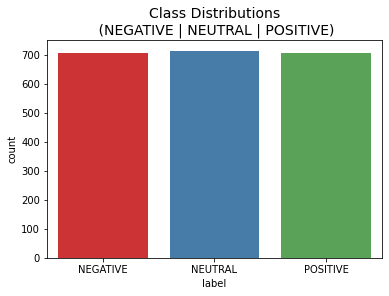

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display the class distritution.
sns.countplot(x='label', data=df, palette="Set1")
plt.title('Class Distributions\n (NEGATIVE | NEUTRAL | POSITIVE)', fontsize=14)

In [ ]:
df['label'].value_counts()

NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64

In [ ]:
print('NEUTRAL:', round(df['label'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('POSITIVE:', round(df['label'].value_counts()[1]/len(df)*100, 2), '% of the dataset')
print('NEGATIVE:', round(df['label'].value_counts()[2]/len(df)*100, 2), '% of the dataset')

NEUTRAL: 33.58 % of the dataset
POSITIVE: 33.21 % of the dataset
NEGATIVE: 33.21 % of the dataset


In [ ]:
encode = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} )
df_encoded = df.replace(encode)
X = df_encoded.drop(['label'], axis=1)
y = df_encoded['label']
print(X.shape, y.shape)

(2132, 2548) (2132,)


In [ ]:
from sklearn.preprocessing import StandardScaler
# Apply StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
from keras.utils import to_categorical

# Converts a class vector (integers) to binary class matrix.
y = to_categorical(y)
y

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X.shape[1]))
print(X_train.shape, X_test.shape)

(1705, 2548) (427, 2548) (1705, 3) (427, 3)
(1705, 1, 2548) (427, 1, 2548)


STACKED LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM

tf.keras.backend.clear_session()

model = Sequential()
model.add(LSTM(128, input_shape=(1,X_train.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            1370624   
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 1,391,331
Trainable params: 1,391,331
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
earlyStop = EarlyStopping(monitor="val_acc", verbose=2, mode='min', patience=50)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test), callbacks=[earlyStop])

Epoch 1/100
54/54 [==============================] - 4s 28ms/step - loss: 0.7546 - acc: 0.6594 - val_loss: 0.2186 - val_acc: 0.9251
Epoch 2/100
54/54 [==============================] - 1s 17ms/step - loss: 0.4777 - acc: 0.8665 - val_loss: 0.1635 - val_acc: 0.9321
Epoch 3/100
54/54 [==============================] - 1s 17ms/step - loss: 0.2678 - acc: 0.9114 - val_loss: 0.1583 - val_acc: 0.9344
Epoch 4/100
54/54 [==============================] - 1s 17ms/step - loss: 0.2355 - acc: 0.9266 - val_loss: 0.1468 - val_acc: 0.9274
Epoch 5/100
54/54 [==============================] - 1s 18ms/step - loss: 0.2029 - acc: 0.9304 - val_loss: 0.1361 - val_acc: 0.9391
Epoch 6/100
54/54 [==============================] - 1s 17ms/step - loss: 0.1548 - acc: 0.9380 - val_loss: 0.1413 - val_acc: 0.9344
Epoch 7/100
54/54 [==============================] - 1s 17ms/step - loss: 0.1810 - acc: 0.9443 - val_loss: 0.1596 - val_acc: 0.9251
Epoch 8/100
54/54 [==============================] - 1s 17ms/step - loss: 0.

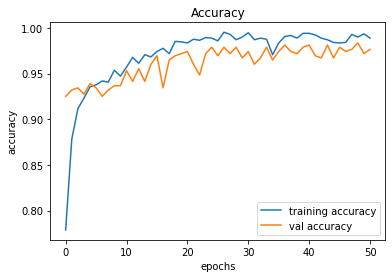

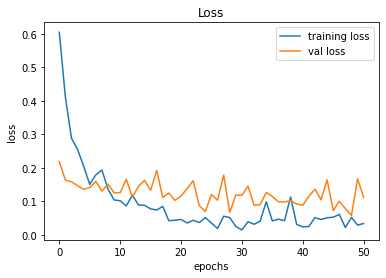

In [ ]:
# Plot graphs
plt.figure(0)
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [ ]:
# Final model evaluation
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 97.66%


BiLSTM

In [ ]:
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

model = Sequential()
model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(1,X_train.shape[2]))))
model.add(RepeatVector(3))
model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True)))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mae', optimizer='adam', metrics=['acc'])

earlyStop = EarlyStopping(monitor="val_acc", verbose=2, mode='min', patience=30)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test), callbacks=[earlyStop])

Epoch 1/100
54/54 [==============================] - 9s 86ms/step - loss: 0.4294 - acc: 0.7116 - val_loss: 0.2842 - val_acc: 0.8407
Epoch 2/100
54/54 [==============================] - 4s 72ms/step - loss: 0.2914 - acc: 0.8376 - val_loss: 0.2331 - val_acc: 0.8501
Epoch 3/100
54/54 [==============================] - 4s 72ms/step - loss: 0.2410 - acc: 0.8534 - val_loss: 0.2230 - val_acc: 0.8368
Epoch 4/100
54/54 [==============================] - 4s 72ms/step - loss: 0.2221 - acc: 0.8633 - val_loss: 0.1455 - val_acc: 0.9407
Epoch 5/100
54/54 [==============================] - 4s 73ms/step - loss: 0.1797 - acc: 0.9465 - val_loss: 0.0923 - val_acc: 0.9493
Epoch 6/100
54/54 [==============================] - 4s 73ms/step - loss: 0.1382 - acc: 0.9503 - val_loss: 0.0834 - val_acc: 0.9555
Epoch 7/100
54/54 [==============================] - 4s 73ms/step - loss: 0.0901 - acc: 0.9632 - val_loss: 0.0825 - val_acc: 0.9602
Epoch 8/100
54/54 [==============================] - 4s 72ms/step - loss: 0.

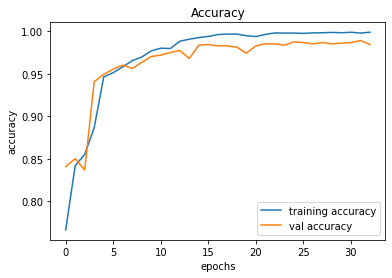

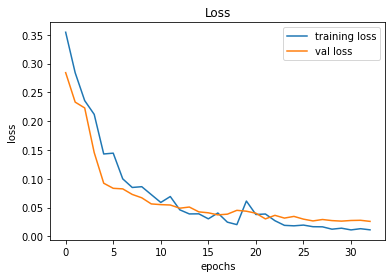

In [ ]:
# Plot Graphs
plt.figure(0)
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# Final model evaluation
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 98.44%
